### Ensemble Clustering

We use an ensemble clustering method to find clusters in the data. We start by loading the data and dropping irrelevant columns. We then create 8 different data sets, and create 2-9 clusters for each data set. Using the Silhouette Score, Davies Bouldin Score, and Calinski Harabasz score, we determine the optimal number of clusters.

N.B.: This notebook takes a few minutes to run.

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from itertools import chain
from collections import Counter
from networkx.algorithms import bipartite
from scipy.sparse import linalg
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import silhouette_score, davies_bouldin_score,  \
                        calinski_harabasz_score, homogeneity_score

In [5]:
# Load necessary data, drop irrelevant columns
data = pd.read_csv('results/output.csv')
outlier_data = pd.read_csv('results/results_with_outliers.csv')

filenames = data['file']
data = data.drop(columns = 'file')

to_drop = ['apls_count', 'niu_count', 'npl_count', 'npnn_count', 
           'npnn_count_relative', 'npun_count', 'npun_count_relative', 
           'npvr_count', 'nrgv_count', 'nrl_count', 'nrvr_count', 
           'nvr_count', 'nscm_count', 'nmo_count', 'nimpp_count']

data = data.drop(columns=to_drop)
data = data.dropna()
print("Data shape after dropping na columns and rows: ", data.shape)
data.head()

Data shape after dropping na columns and rows:  (9285, 50)


,atss_count,bloc_count,bloc_count_relative,cloc_count,cloc_count_relative,dpt_count,etp_count,loc_count,nbeh_count,nbeh_count_relative,...,nsh_count,ntkn_count,ntnn_count,ntnn_count_relative,nts_count,ntun_count,ntun_count_relative,ntvr_count,nun_count,nun_count_relative
0,3.0,0,0.0,0,0.00,2,-5.81,25,0.0,0.0,...,5.0,113,1.0,0.11,9.0,8.0,0.89,5.0,8.0,1.00
1,10.0,0,0.0,0,0.00,2,-4.01,10,0.0,0.0,...,0.0,31,0.0,0.00,1.0,1.0,1.00,5.0,2.0,1.00
2,9.0,0,0.0,2,0.02,5,-5.57,132,0.0,0.0,...,0.0,373,0.0,0.00,15.0,7.0,0.47,8.0,7.0,0.29
3,6.0,0,0.0,0,0.00,2,-5.34,37,0.0,0.0,...,1.0,133,0.0,0.00,6.0,6.0,1.00,4.0,6.0,1.00
4,13.0,0,0.0,0,0.00,3,-4.30,13,0.0,0.0,...,0.0,34,1.0,1.00,1.0,0.0,0.00,2.0,2.0,1.00


In [6]:
N_ENSEMBLES = 100
N_CLUSTERS = 6

We create eight different datasets:
- A set containing all metrics and all data
- A set containing only the 'absolute' columns, not their relative counterpart
- A set containing only the relative counterparts of the count metrics that have one.
- A set where all the highly correlated columns, as found in Notebook 1, are removed.
- For each of the above data set, we create an equivalent where outliers are dropped.

In [7]:
all_metrics = data
all_no_outliers = outlier_data[outlier_data['outlier'] == 0]
all_no_outliers = all_no_outliers.drop(columns=['outlier_scores', 'outlier', 'file'])
relative_cols = [col for col in data.columns if 'relative' in col]
absolute = data.drop(columns = relative_cols)
absolute_no_outliers = outlier_data[outlier_data['outlier'] == 0].drop(columns = relative_cols)
absolute_no_outliers = absolute_no_outliers.drop(columns=['outlier_scores', 'outlier', 'file'])
absolute_cols = [col.strip('relative').rstrip('_') for col in relative_cols]
relative = data.drop(columns = absolute_cols)
relative_no_outliers = outlier_data[outlier_data['outlier'] == 0].drop(columns= absolute_cols)
relative_no_outliers = relative_no_outliers.drop(columns=['outlier_scores', 'outlier', 'file'])
no_corr_cols = ['ncd_count', 'nkeys_count', 'nnnv_count', 'ntkn_count', 'nun_count', 'nco_count',
               'nemd_count', 'ntun_count', 'ntnn_count_relative', 'nts_count', 'ntvr_count']
no_corr_metrics = data.drop(columns=no_corr_cols)
no_corr_metrics_no_outliers = outlier_data[outlier_data['outlier'] == 0].drop(columns=no_corr_cols)
no_corr_metrics_no_outliers = no_corr_metrics_no_outliers.drop(columns=['outlier_scores', 'outlier', 'file'])

### Random projection based cluster ensemble
- Randomly generated linear transformation, represented by a $ d\times d'$ matrix $R$
- $x_{ij}\sim N(0,1) \forall i\in d, j\in d'$ i.i.d.
- Normalize columns to unit length
- d' needs to preserve 90% of the data variance. If dimensionalities are still high, requirements may be relaxed to preserving 80% of data variance. May be equal to d' from PCA approach
- Perform KMeans on the resulting matrix X'

We suspect that four clusters exist in our data.

In [8]:
def create_random_projection(data, n_components, rng):
    # rng = np.random.RandomState(42)
    transformer = GaussianRandomProjection(n_components=n_components, random_state = rng)
    X_new = transformer.fit_transform(data)
    return X_new

def create_clusters(list_of_projections, n_clusters):
    list_of_clusterings = []
    for proj in list_of_projections:
        kmeans = KMeans(n_clusters=n_clusters).fit(proj)
        list_of_clusterings.append(kmeans.labels_)
    return list_of_clusterings

def create_metaclusters(list_of_clusterings, n_clusters):
    metaclusters = []
    for index, clustering in enumerate(list_of_clusterings):
        new_clustering = [str(cluster + n_clusters*index) for cluster in clustering]
        metaclusters.append(new_clustering)
    return metaclusters


We're using the Hybrid Bipartite Graph Formulation (HBGF) as our consensus function, and Spectral Graph Partitioning (SPEC) as our partitioning function of the created bipartite graph

In [9]:
def create_bipartite_graph(metaclusters):
    B = nx.Graph()
    # Add cluster nodes and instance nodes
    B.add_nodes_from(set(chain(*metaclusters)), bipartite=0)  # Cluster nodes
    B.add_nodes_from(range(len(metaclusters[0])), bipartite=1)  # Instance nodes
    # Add edges
    B.add_edges_from([(clust, instance) for cl in metaclusters for instance, clust in enumerate(cl)])
    return B

def k_largest_eigenvectors(eigenvals, eigenvecs, k):
    largest_vecs = np.array([eigenvecs[:,index] for index in np.argsort(eigenvals)[:k]])
    return largest_vecs

def normalize_rows(matrix):
    return [matrix[:,i]/np.linalg.norm(matrix[:,i]) for i in range(len(matrix[0]))]

def ensemble_clustering(data, n_clusters, n_ensembles):
    random_projections = [create_random_projection(data, 2, i) for i in range(n_ensembles)]
    clustering = create_clusters(random_projections, n_clusters)
    metaclusters = create_metaclusters(clustering, n_clusters)

    B = create_bipartite_graph(metaclusters)
    NLM = nx.normalized_laplacian_matrix(B)
    eigenvals, eigenvecs = linalg.eigs(NLM)
    eigenvals = np.real(eigenvals)
    eigenvecs = np.real(eigenvecs)
    KLEV = k_largest_eigenvectors(eigenvals, eigenvecs, n_clusters)
    normalized_rows = normalize_rows(KLEV)

#     kmeans = KMeans(n_clusters=n_clusters).fit(normalized_rows)
#     results = kmeans.labels_[n_clusters*n_ensembles:]

    kmeans = KMeans(n_clusters=n_clusters).fit(normalized_rows[n_clusters*n_ensembles:])
    results = kmeans.labels_
    
    return results

In [10]:
def range_of_clusters(data, min_clusters, max_clusters, n_ensembles):
    cluster_evaluation_metrics = {'silhouette_score': silhouette_score,
                             'davies_bouldin_score': davies_bouldin_score,
                              'calinski_harabasz_score': calinski_harabasz_score,
                             }

    n_clusters = range(min_clusters,max_clusters)
    
    scores ={'silhouette_score': [],
             'davies_bouldin_score': [],
              'calinski_harabasz_score': [],
             }
    
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    
    for c in n_clusters:
        print('number of clusters: {}'.format(c))
        
        random_projections = [create_random_projection(data, 2, i) for i in range(n_ensembles)]
        clustering = create_clusters(random_projections, c)
        metaclusters = create_metaclusters(clustering, c)
        
        B = create_bipartite_graph(metaclusters)
        NLM = nx.normalized_laplacian_matrix(B)
        eigenvals, eigenvecs = linalg.eigs(NLM)
        eigenvals = np.real(eigenvals)
        eigenvecs = np.real(eigenvecs)
        KLEV = k_largest_eigenvectors(eigenvals, eigenvecs, c)
        normalized_rows = normalize_rows(KLEV)
        
        kmeans = KMeans(n_clusters=c).fit(normalized_rows)
        results = kmeans.labels_[c*n_ensembles:]
        
        for name, method in cluster_evaluation_metrics.items():
            res = method(np.array(data), results)
            print('   {} score: {}'.format(name,res))
            scores[name].append(res)
            
    return scores

def plot_scores(scores):
    fig, (ax1, ax2, ax3) = plt.subplots(3, gridspec_kw={'hspace': 0.7})
    x = np.linspace(2,10,8)
    ax1.plot(range(2,10),scores['silhouette_score'])
    ax2.plot(range(2,10),scores['davies_bouldin_score'])
    ax3.plot(range(2,10),scores['calinski_harabasz_score'])

    ax1.set_xticks(range(2,10))
    ax2.set_xticks(range(2,10))
    ax3.set_xticks(range(2,10))
    ax1.set_title('silhouette_score')
    ax2.set_title('davies_bouldin_score')
    ax3.set_title('calinski_harabasz_score')
    plt.show();

In [11]:
datasets = {'all_metrics':all_metrics, 
            'all_no_outliers':all_no_outliers, 
            'absolute':absolute, 
            'absolute_no_outliers':absolute_no_outliers, 
            'relative':relative, 
            'relative_no_outliers':relative_no_outliers,
           'no_corr_metrics': no_corr_metrics,
            'no_corr_metrics_no_outliers': no_corr_metrics_no_outliers}

scores = []
for name, df in datasets.items():
    print('dataset: {}'.format(name))
    res = range_of_clusters(df, 2, 10, 100)
    scores.append((name, res))

dataset: all_metrics
number of clusters: 2
   silhouette_score score: 0.7710044896825864
   davies_bouldin_score score: 0.7578527217915132
   calinski_harabasz_score score: 4749.006584697972
number of clusters: 3
   silhouette_score score: 0.5682827940959346
   davies_bouldin_score score: 1.1327193587188014
   calinski_harabasz_score score: 1049.7526043459552
number of clusters: 4
   silhouette_score score: 0.6745786892844367
   davies_bouldin_score score: 0.7930681934265302
   calinski_harabasz_score score: 3555.9624715064674
number of clusters: 5
   silhouette_score score: 0.49243398222350715
   davies_bouldin_score score: 0.9506282816070497
   calinski_harabasz_score score: 3480.8787328154685
number of clusters: 6
   silhouette_score score: 0.629203072098171
   davies_bouldin_score score: 0.6096461385288089
   calinski_harabasz_score score: 12978.332731355224
number of clusters: 7
   silhouette_score score: 0.6044583852137068
   davies_bouldin_score score: 0.6138118290630157
   cali

   silhouette_score score: 0.7622988371648064
   davies_bouldin_score score: 0.8188144600114196
   calinski_harabasz_score score: 3689.0245436847367
number of clusters: 3
   silhouette_score score: 0.6723045089715319
   davies_bouldin_score score: 2.349308198314499
   calinski_harabasz_score score: 2225.6429471129654
number of clusters: 4
   silhouette_score score: 0.6779250384889745
   davies_bouldin_score score: 1.0552140428130288
   calinski_harabasz_score score: 2787.3251777676765
number of clusters: 5
   silhouette_score score: 0.3728843911166603
   davies_bouldin_score score: 0.9361319154041496
   calinski_harabasz_score score: 3093.359394266358
number of clusters: 6
   silhouette_score score: 0.5855649925654205
   davies_bouldin_score score: 0.7624960785757532
   calinski_harabasz_score score: 7778.869958181244
number of clusters: 7
   silhouette_score score: 0.5795501150543106
   davies_bouldin_score score: 0.7445088222623479
   calinski_harabasz_score score: 8284.40769008829
n

dataset: all metrics


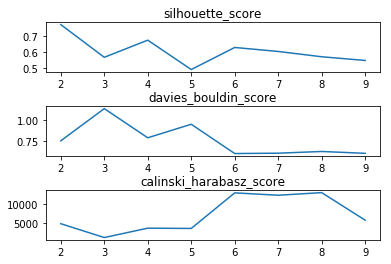

dataset: all no outliers


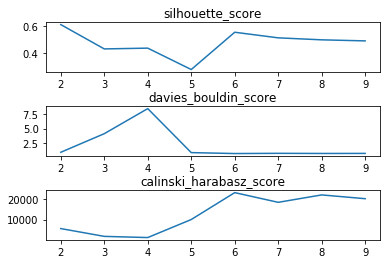

dataset: absolute


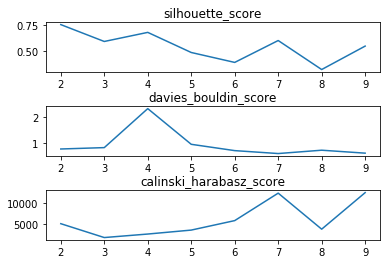

dataset: absolute no outliers


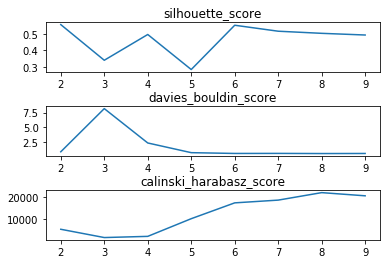

dataset: relative


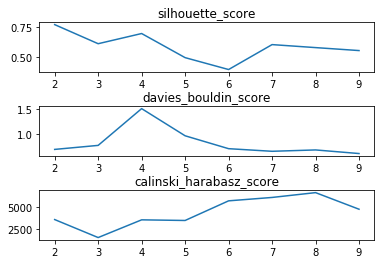

dataset: relative no outliers


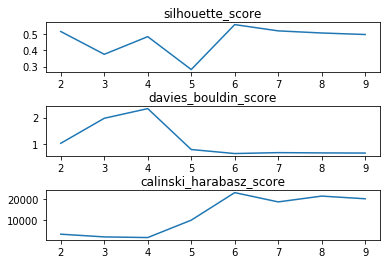

dataset: no corr metrics


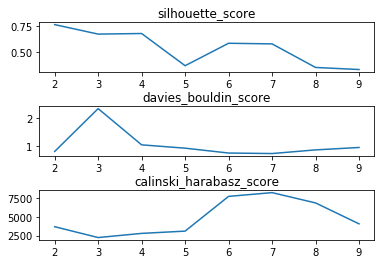

dataset: no corr metrics no outliers


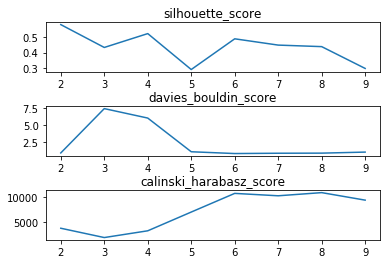

In [12]:
for name, score in scores:
    print('dataset: {}'.format(name.replace("_", " ")))
    plot_scores(score)

For each data set, we find 6 to be the ideal number of clusters.

In [14]:
datasets = {'all_metrics':all_metrics, 
            'all_no_outliers':all_no_outliers, 
            'absolute':absolute, 
            'absolute_no_outliers':absolute_no_outliers, 
            'relative':relative, 
            'relative_no_outliers':relative_no_outliers,
           'no_corr_metrics': no_corr_metrics,
            'no_corr_metrics_no_outliers': no_corr_metrics_no_outliers}

for name, df in datasets.items():
    print(name)
    res = ensemble_clustering(df, N_CLUSTERS, N_ENSEMBLES)
    df['clusters'] = res
    df.to_csv('results/{}_clusters.csv'.format(name))
    

all_metrics
all_no_outliers
absolute
absolute_no_outliers
relative
relative_no_outliers
no_corr_metrics
no_corr_metrics_no_outliers
